## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on MNIST data, a classification task.

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from utils import GradientRelativeEntropy

tf.random.set_seed(42)

2024-03-23 11:33:27.628826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## The MNIST Data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape([-1, 28*28]) / 255.0
x_test = x_test.astype('float32').reshape([-1, 28*28]) / 255.0
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

## Train a Model with Gradient Loss

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(128, 'relu'),
    tf.keras.layers.Dense(10, 'softmax')
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [4]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        loss = gradient_loss_fn(x, y)
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return loss

In [5]:
def evaluate(model):
    return accuracy_score(y_test, tf.argmax(model(x_test), axis=1))

In [6]:
ds = tf.data.Dataset.from_tensor_slices(
    (x_train, tf.one_hot(y_train, 10))
)
ds = ds.batch(100)

In [7]:
for epoch in range(20):
    for x, y in ds:
        loss = train_step(x, y)
    print(epoch, loss.numpy(), evaluate(model))

0 0.014591954 0.9395
1 0.014467722 0.95
2 0.01419764 0.9641
3 0.01406077 0.959
4 0.013714643 0.9686
5 0.014020237 0.9705
6 0.013640853 0.9714
7 0.013770687 0.9683
8 0.013390199 0.973
9 0.013947699 0.9738
10 0.013732208 0.9768
11 0.013752709 0.9732
12 0.013714328 0.9714
13 0.013591561 0.9705
14 0.0134965805 0.9732
15 0.014039773 0.9764
16 0.013397279 0.9777
17 0.0133749265 0.9746
18 0.013436242 0.9737
19 0.013372349 0.9779


In [8]:
evaluate(model)

0.9779

## Baseline Model with Usual Loss

In [9]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, 'softmax')
])

In [10]:
baseline_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [11]:
baseline_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/20
1875/1875 - 2s - loss: 0.2324 - accuracy: 0.9317 - val_loss: 0.1206 - val_accuracy: 0.9630 - 2s/epoch - 1ms/step
Epoch 2/20
1875/1875 - 2s - loss: 0.0961 - accuracy: 0.9702 - val_loss: 0.1044 - val_accuracy: 0.9682 - 2s/epoch - 971us/step
Epoch 3/20
1875/1875 - 2s - loss: 0.0679 - accuracy: 0.9787 - val_loss: 0.0875 - val_accuracy: 0.9733 - 2s/epoch - 978us/step
Epoch 4/20
1875/1875 - 2s - loss: 0.0515 - accuracy: 0.9836 - val_loss: 0.0771 - val_accuracy: 0.9762 - 2s/epoch - 965us/step
Epoch 5/20
1875/1875 - 2s - loss: 0.0408 - accuracy: 0.9867 - val_loss: 0.0843 - val_accuracy: 0.9755 - 2s/epoch - 967us/step
Epoch 6/20
1875/1875 - 2s - loss: 0.0341 - accuracy: 0.9885 - val_loss: 0.0742 - val_accuracy: 0.9802 - 2s/epoch - 960us/step
Epoch 7/20
1875/1875 - 2s - loss: 0.0279 - accuracy: 0.9905 - val_loss: 0.0922 - val_accuracy: 0.9773 - 2s/epoch - 956us/step
Epoch 8/20
1875/1875 - 2s - loss: 0.0237 - accuracy: 0.9921 - val_loss: 0.1034 - val_accuracy: 0.9728 - 2s/epoch - 960us

In [12]:
evaluate(baseline_model)

0.9758

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [13]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.5, 50)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.normal(tf.shape(x_test)) * stddev
    model_accs.append(
        accuracy_score(y_test, tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(y_test, tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.12it/s]


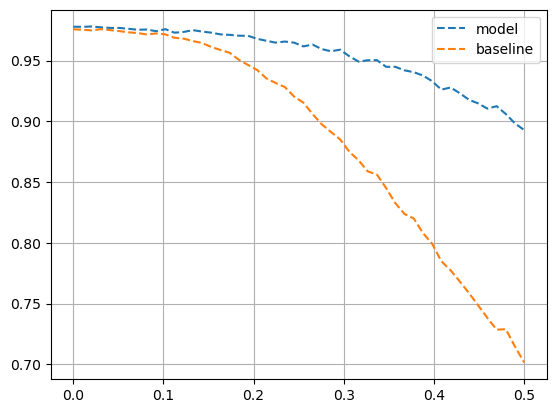

In [14]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## MNIST-C

In this section, we are to exame the model and the baseline model on the [MNIST-C](https://github.com/google-research/mnist-c) dataset, which was designed for evaluating the robustness of models trained on MNIST dataset.

We have downloaded the ZIP file from [here](https://zenodo.org/records/3239543), and unpacked into the `data` folder.

In [15]:
print('noise type : model accuracy : baseline accuracy : exceed')
for noise_type in os.listdir('data/mnist_c'):
    x_eval = np.load(f'data/mnist_c/{noise_type}/test_images.npy')
    y_eval = np.load(f'data/mnist_c/{noise_type}/test_labels.npy')
    
    x_eval = x_eval.astype('float32').reshape([-1, 28*28]) / 255.0
    y_eval = y_eval.astype('float32')

    model_eval = accuracy_score(y_eval, tf.argmax(model(x_eval), axis=1))
    baseline_eval = accuracy_score(y_eval, tf.argmax(baseline_model(x_eval), axis=1))
    exceed = (model_eval - baseline_eval) / baseline_eval
    
    print(f'{noise_type} : {model_eval} : {baseline_eval} : {exceed*100:.1f}%')

noise type : model accuracy : baseline accuracy : exceed
dotted_line : 0.9566 : 0.901 : 6.2%
stripe : 0.3644 : 0.1905 : 91.3%
shot_noise : 0.9679 : 0.9628 : 0.5%
rotate : 0.8342 : 0.8459 : -1.4%
motion_blur : 0.863 : 0.8549 : 0.9%
impulse_noise : 0.9312 : 0.7803 : 19.3%
spatter : 0.9582 : 0.9184 : 4.3%
canny_edges : 0.7086 : 0.6325 : 12.0%
zigzag : 0.85 : 0.6802 : 25.0%
glass_blur : 0.9493 : 0.9376 : 1.2%
brightness : 0.3349 : 0.2423 : 38.2%
scale : 0.6704 : 0.6593 : 1.7%
fog : 0.2648 : 0.1903 : 39.1%
identity : 0.9779 : 0.9758 : 0.2%
translate : 0.2889 : 0.3124 : -7.5%
shear : 0.9345 : 0.9207 : 1.5%


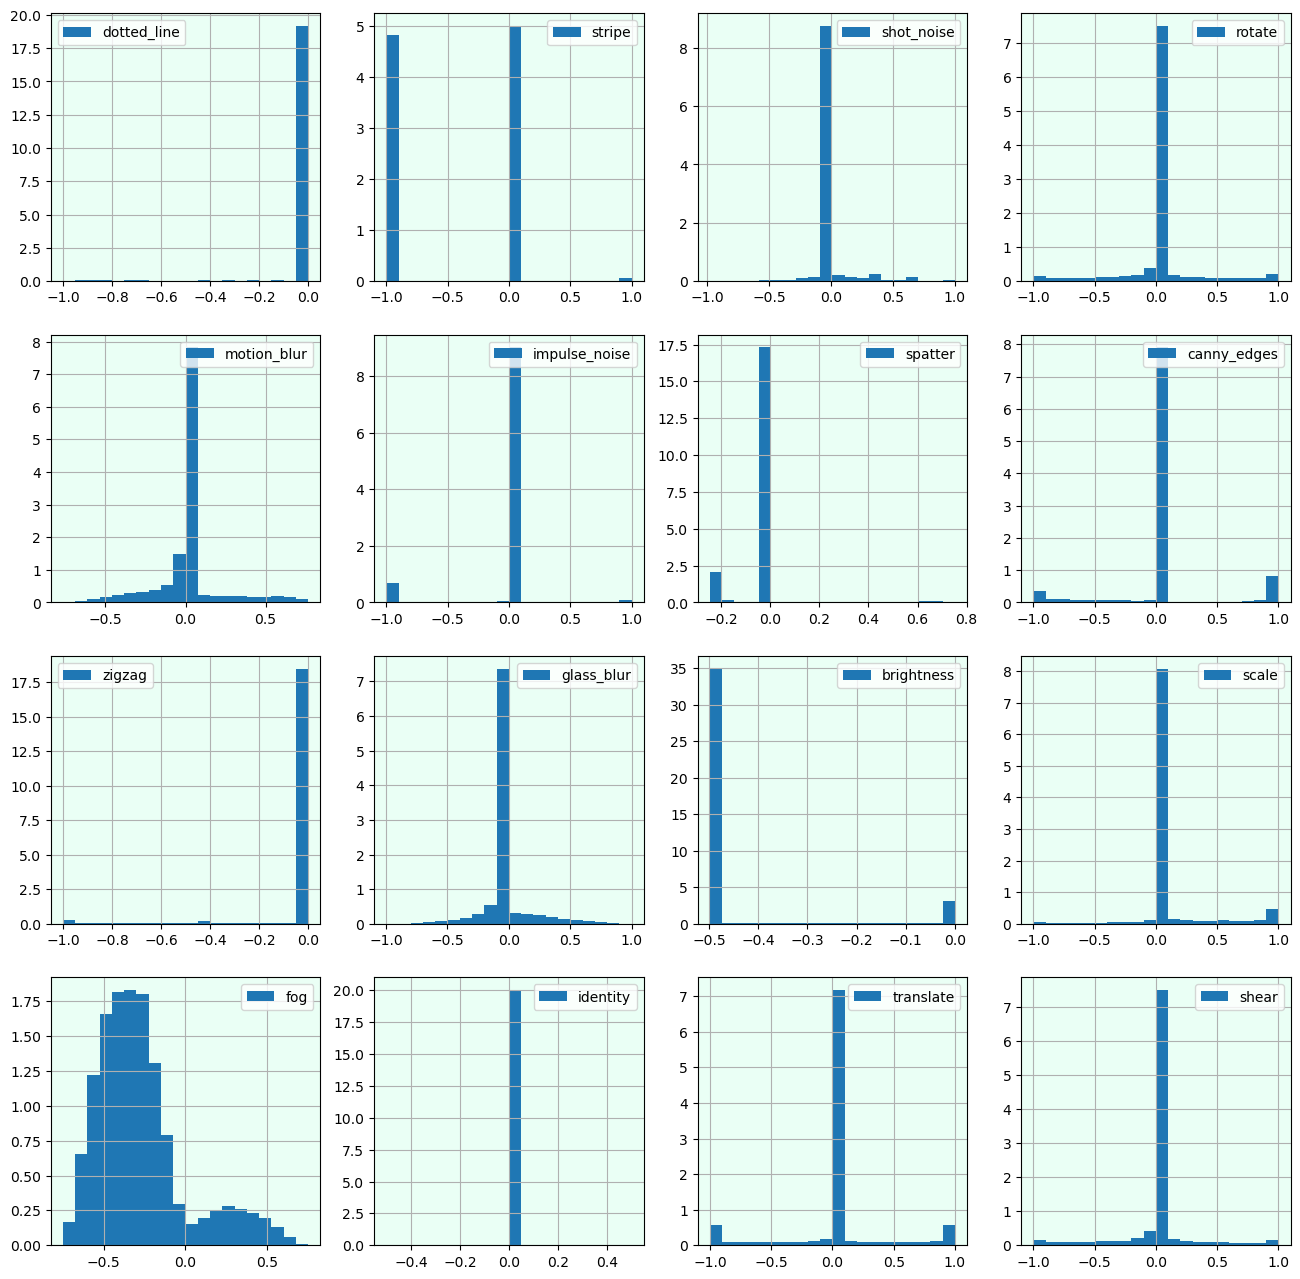

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, noise_type in enumerate(os.listdir('data/mnist_c')):
    j = i // 4
    k = i % 4
    ax = axs[j][k]

    x_eval = np.load(f'data/mnist_c/{noise_type}/test_images.npy')
    x_eval = x_eval.astype('float32').reshape([-1, 28*28]) / 255.0

    diff = (x_test - x_eval).reshape([-1])
    ax.hist(diff, 20, label=noise_type, density=True)
    ax.legend()
    ax.grid()
    ax.set_facecolor('#eafff5')

plt.show()

## Conclusion

- We have trained a simple feed-forward neural network on the MNIST dataset by minimizing loss gradients.
- The performance examed by accuracy approaches the baseline, which is trained by minimizing loss.
- For simple Gaussian noise, the robustness is greatly out-performs the baseline.
- We also examed more types of noise, using the MNIST-C dataset. We find that the robustness is significant on the types "dotted line" and "inpulse noise". Temporally, there is no hint about when robustness out-performs the baseline.